In [35]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

#if you want to run the code again you need new token for the SumMeframes dataset
CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'summeframes:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2220027%2F3711611%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240608%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240608T060553Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0735a56b2d90ad235d73679cc6452e677ba9aabe811c83a7bcad1ff3acb606ebdf45a16d64f5d5eda7e3a2f331ebe6b3d4e72a979e0fbf3d2132e7f6234ed38300a143c25d8e8ee3cb2b64fde838466a220ab61e1ea4f68b0858b24af3bfb878bc6a52e4644e2fdd07bb8096a6ee230febd20fb65c73259ed953be700e670277c34e072b384f2dc5b36ef3b73989fe79ac109c24040e53bff017031b56be151c1c287c5666b73b48fe74cc89a8318eaa52a2c5618a48137c871106a1fcf7718b8b759e133be33c407fad9218771be7e0d85034b37e723c715fdf7a7335be6ac34afec9db67a7b0d8bba273004df7cd2a99c3b54fdd5bab7ee24d6b8de12e9996'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2120242016 bytes downloaded
Downloaded and uncompressed: summeframes
Data source import complete.


In [36]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, ToPILImage, Resize, ConvertImageDtype
import torchvision.models as models
from torchvision.io import read_image
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import cv2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

image_transformation = nn.Sequential(
    Resize(size=(140, 320)),
    ConvertImageDtype(torch.float),
)

class SumMeDataset(Dataset):
    def __init__(self, annotations_filename, img_dir, transform=None, target_transform=None):

        self.annotation_filename = annotations_filename
        self.annotation = pd.read_csv(annotations_filename, header=0)

        self.img_dir = img_dir
        self.video_name = img_dir.split('/')[-1]
        self.frame_labels = self.annotation[self.annotation['video_name'] == self.video_name]['gt_score']

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.frame_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, 'img_' + str(idx + 1).zfill(5) + '.jpg')
        image = read_image(img_path)
        label = self.frame_labels.iloc[idx]

        if self.transform:
            image = self.transform(image)
            image = image.to(device)
#         if self.target_transform:
#         label = label * 100
#             label = self.target_transform(label)

        return image, label, idx

def show(imgs):
    """Arrange images in a grid formation; helper function of make_grid"""
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20, 16))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [37]:
# get device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device.upper()}")

annotations_filename = './frames/annotation.csv'
annotations_filename = '../input/summeframes/frames/annotation.csv' # kaggle

batch_size = 80 # needs to be large enough

# instantiating the dataset
videos_root = './frames/Jumps'
videos_root = '../input/summeframes/frames/Jumps' # kaggle
dataset = SumMeDataset(annotations_filename, videos_root, transform=image_transformation)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)
print(f'{videos_root} dataset has {len(dataset)} samples')

videos_root = '../input/summeframes/frames/Base_jumping' # Kaggle
dataset2 = SumMeDataset(annotations_filename, videos_root, transform=image_transformation)
dataloader2 = DataLoader(dataset2, batch_size=batch_size, shuffle=False, drop_last=True)
print(f'{videos_root} dataset has {len(dataset2)} samples')

videos_root = '../input/summeframes/frames/Valparaiso_Downhill' # kaggle
dataset3 = SumMeDataset(annotations_filename, videos_root, transform=image_transformation)
dataloader3 = DataLoader(dataset2, batch_size=batch_size, shuffle=False, drop_last=True)
print(f'{videos_root} dataset has {len(dataset3)} samples')


# features, labels = next(iter(dataloader))
# print("Data Loader:")
# print(f"Feature batch shape: {features.size()}")
# print(f"Labels batch shape: {labels.size()}")

# load validation dataset too
validation_video_root = './frames/Cooking'
validation_video_root = '../input/summeframes/frames/Cooking'

validation_dataset = SumMeDataset(annotations_filename, validation_video_root, transform=image_transformation)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
print(f'{validation_video_root} dataset has {len(validation_dataset)} samples')

print(dataset[0][0].shape)
feature, label, _ = dataset[256]
label

Using: CUDA
../input/summeframes/frames/Jumps dataset has 950 samples
../input/summeframes/frames/Base_jumping dataset has 4729 samples
../input/summeframes/frames/Valparaiso_Downhill dataset has 5178 samples
../input/summeframes/frames/Cooking dataset has 1286 samples
torch.Size([3, 140, 320])


0.3333333333333333

## Encoder

In [38]:
# encoder
feature_size = 256

class new_resNext(torch.nn.Module):
    def __init__(self, fc_size=2048, large=False, pretrained=True):
        super(new_resNext,self).__init__()
        if large:
            self.model = models.resnext101_32x8d(pretrained=pretrained)
        else:
            self.model = models.resnext50_32x4d(pretrained=pretrained)

        self.model.fc = torch.nn.Linear(fc_size, feature_size)

    def forward(self,x):
        x = self.model(x)
        return x

new_resNext = new_resNext().to(device) # models move to different device inplace

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## RNN

In [39]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # defining the layers
        self.rnn = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.out = nn.Linear(16, output_size)

    def forward(self, input):
        output, hidden = self.rnn(input)
        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        output = self.out(output)

        return output, hidden


# want more hidden_size (up to 1024)
# 2-4 layers
model = Model(feature_size, 1, 512, 4)
model.to(device)

def loss_func(pred, y):
    if (y > 0.5).any():
        return nn.MSELoss()(pred, y) * 2
    elif (y > 0.75).any():
        return nn.MSELoss()(pred, y) * 4
    else:
        return nn.MSELoss()(pred, y)


# define loss and optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

load = True # swtich this when evaulating
if load:
    model = torch.load("/content/trained_model-20220530-082314")
    print(model.eval())

Model(
  (rnn): LSTM(256, 512, num_layers=4, batch_first=True)
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=1, bias=True)
)


## Training

In [40]:
from tqdm.notebook import tqdm

def test_loop(dataloader, model, num_samples):
    """Iterate through the whole dataset and calculate average loss"""
    test_loss = 0
    preds = np.zeros(num_samples) - 1

    with torch.no_grad():
        for features, labels, idxs in tqdm(dataloader):

            # encode the features
            features = features.to(device)
            labels = labels.to(device)
            labels = torch.reshape(labels, (1, batch_size, 1))

            encoded_features = new_resNext(features)
            batched_seq = torch.reshape(encoded_features, (1, batch_size, feature_size))

            pred, _= model(batched_seq)
            test_loss += loss_func(pred, labels.float()).item()

            for index, pred in zip(idxs, torch.flatten(pred)):
                preds[index] = pred

    test_loss /= batch_size
    print(f'test_loss = {test_loss}')
    return test_loss, preds

# TRAINING LOOP
def train_loop(dataloaders, model):
    """One iteration of training"""
    train_loss = 0
    for dataloader in dataloaders:
        for features, labels, _ in tqdm(dataloader):

            # move features and labels to GPU
            features = features.to(device) # data doesn't move to different device inplace !
            labels = labels.to(device)
            labels = torch.reshape(labels, (1, batch_size, 1))

            optimizer.zero_grad()

            # encode image features using resNext and reshape
            encoded_features = new_resNext(features)
            batched_seq = torch.reshape(encoded_features, (1, batch_size, feature_size))
            batched_seq.to(device)

            output, hidden = model(batched_seq) # forward pass
            loss = criterion(output, labels.float()) # calcualte MSE
#             print(loss)
            train_loss += loss
            loss.backward()
            optimizer.step()

        train_loss /= batch_size
        print(f'training_loss = {train_loss}')

# Train for num_epochs
if not load: # if didn't load the model weights, train
    num_epochs = 5
    dataloaders = [dataloader, dataloader2, dataloader3] # add new dataloader here
    for epoch in range(num_epochs):
        print(f'epoch {epoch}')
        train_loop(dataloaders, model)
        test_loss, preds = test_loop(validation_dataloader, model, len(validation_dataset))

## Testing

In [41]:
test_loss, preds = test_loop(dataloader, model, len(dataset))
print("min:", np.min(preds[preds != -1]), "\nmax:", np.max(preds), "\navg:", np.average(preds), "\nmedian:", np.median(preds), len(preds[preds > 0.5])) # show the stats of predicted values

  0%|          | 0/11 [00:00<?, ?it/s]

test_loss = 0.017879832883772907
min: 0.0554034560918808 
max: 0.07510273903608322 
avg: -0.021657322872626155 
median: 0.055404460057616234 0


In [42]:
def visualize_results(preds, dataset, num_frames=5):

    # find top ranked frames
    selected_img_i = []
    top_imgs_i = np.argsort(preds)
    selected = np.zeros(len(preds))
    for img_i in reversed(top_imgs_i):
        if selected[img_i] != 1:
            selected[img_i-len(dataset)//20 : img_i+len(dataset)//20] = 1
            feature, label, _ = dataset[img_i]
            print(round(preds[img_i], 5), round(label, 5))
            selected_img_i.append(img_i)
        if len(selected_img_i) >= num_frames:
            break

    best_features = []
    for idx in np.sort(selected_img_i):
        feature, label, _ = dataset[idx]
        best_features.append(feature)
    grid = make_grid(best_features, nrow=5)
#     show(grid)

     # used during tuning
 #    top_imgs_i = np.argsort(preds)[-10:]
  #   for img_i in reversed(top_imgs_i):
   #      feature, label, _ = dataset[img_i]
    #     print(img_i, preds[img_i], label)
     #    best_feature.append(feature)

  #   grid = make_grid(best_feature, nrow=5)
   # show(grid)

visualize_results(preds, dataset, num_frames=10)

0.0751 0.0
0.07505 0.93333
0.07501 0.0
0.07493 0.06667
0.07493 0.0
0.07489 0.46667
0.07483 0.06667
0.0748 0.13333
0.07478 0.06667
0.07478 0.0


In [43]:
test_loss, preds = test_loop(dataloader2, model, len(dataset2))
print("min:", np.min(preds[preds != -1]), "\nmax:", np.max(preds), "\navg:", np.average(preds), "\nmedian:", np.median(preds), len(preds[preds > 0.5])) # show the stats of predicted values
visualize_results(preds, dataset2, num_frames=10)

  0%|          | 0/59 [00:00<?, ?it/s]

test_loss = 0.029952155418504843
min: 0.05540226399898529 
max: 0.07624759525060654 
avg: 0.05432701215847498 
median: 0.055404577404260635 0
0.07625 0.38889
0.07513 0.0
0.07512 0.0
0.0751 0.05556
0.07508 0.0
0.07507 0.0
0.07502 0.33333
0.07501 0.22222
0.07501 0.27778
0.075 0.27778


In [44]:
test_loss, preds = test_loop(dataloader3, model, len(dataset3))
print("min:", np.min(preds[preds != -1]), "\nmax:", np.max(preds), "\navg:", np.average(preds), "\nmedian:", np.median(preds), len(preds[preds > 0.5])) # show the stats of predicted values
visualize_results(preds, dataset3, num_frames=10)

  0%|          | 0/59 [00:00<?, ?it/s]

test_loss = 0.029952155418504843
min: 0.05540226399898529 
max: 0.07624759525060654 
avg: -0.037096863557854735 
median: 0.05540446937084198 0
0.07625 0.26667
0.07513 0.26667
0.07512 0.0
0.0751 0.06667
0.07508 0.13333
0.07501 0.26667
0.07501 0.06667
0.075 0.2
0.075 0.0
0.07498 0.2


In [45]:
test_loss, preds = test_loop(validation_dataloader, model, len(validation_dataset))
print("min:", np.min(preds[preds != -1]), "\nmax:", np.max(preds), "\navg:", np.average(preds), "\nmedian:", np.median(preds), len(preds[preds > 0.5])) # show the stats of predicted values
visualize_results(preds, validation_dataset, num_frames=10)

  0%|          | 0/16 [00:00<?, ?it/s]

test_loss = 0.0166643093143648
min: 0.0553901307284832 
max: 0.0757882297039032 
avg: 0.051231956149959824 
median: 0.055404357612133026 0
0.07579 0.0
0.07574 0.58824
0.07552 0.41176
0.07532 0.0
0.0751 0.23529
0.07505 0.0
0.07505 0.05882
0.07504 0.41176
0.07501 0.05882
0.07494 0.05882


In [46]:
torch.save(model.state_dict(), "./saved_model_3_dataset")

In [47]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
torch.save(model, "./trained_model-" + timestr)

In [48]:
# Load the trained model
model = torch.load("./trained_model-" + timestr)

# Evaluate the model on the test set
model.eval()  # Call the eval() method on the model object
test_loss, preds = test_loop(dataloader3, model, len(dataset3))

# Print the statistics of the predicted values
print("min:", np.min(preds[preds != -1]), "\nmax:", np.max(preds), "\navg:", np.average(preds), "\nmedian:", np.median(preds), len(preds[preds > 0.5]))

# Visualize the results
visualize_results(preds, dataset3, num_frames=10)

  0%|          | 0/59 [00:00<?, ?it/s]

test_loss = 0.029952155418504843
min: 0.05540226399898529 
max: 0.07624759525060654 
avg: -0.037096863557854735 
median: 0.05540446937084198 0
0.07625 0.26667
0.07513 0.26667
0.07512 0.0
0.0751 0.06667
0.07508 0.13333
0.07501 0.26667
0.07501 0.06667
0.075 0.2
0.075 0.0
0.07498 0.2


In [49]:
IMG_SIZE = 224
BATCH_SIZE = 64
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [50]:
DATA_FOLDER = '/kaggle/input/summeframes'
TEST_FOLDER = '/kaggle/input/summeframes/frames/Valparaiso_Downhill'
TRAIN_SAMPLE_FOLDER = '/kaggle/input/summeframes/frames/Fire_Domino'
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

def sequence_prediction(path):
    frames = load_video(os.path.join(DATA_FOLDER, TEST_FOLDER,path))
    frame_features, frame_mask = prepare_single_video(frames)
    return model.predict([frame_features, frame_mask])[0]
def display_image_from_video(video_path):

    capture_image = cv2.VideoCapture(video_path)
    ret, frame = capture_image.read()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax.imshow(frame)

Test video path: /content/videoplayback (2).mp4


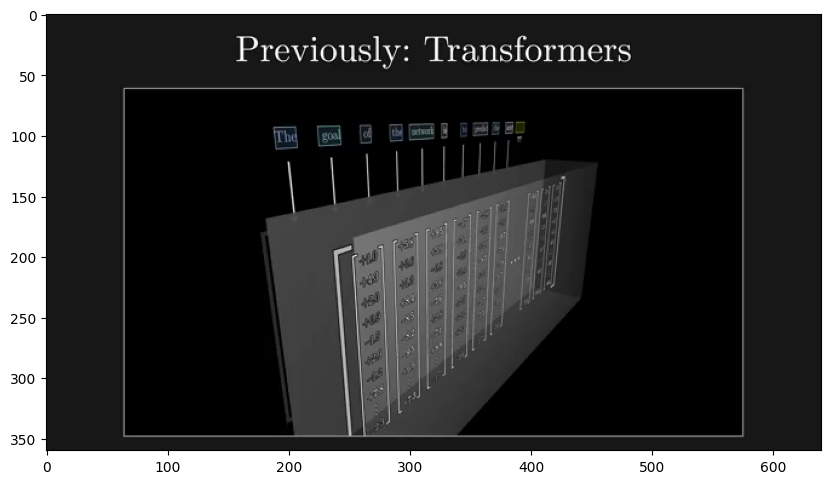

In [52]:
test_video = "/content/videoplayback (2).mp4"
print(f"Test video path: {test_video}")

display_image_from_video(test_video)

In [67]:
!ffmpeg -i testme.mp4 -q:a 0 -map a output_audio.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [68]:
!pip install git+https://github.com/openai/whisper.git

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-8oaf9tdo
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-8oaf9tdo
  Resolved https://github.com/openai/whisper.git to commit ba3f3cd54b0e5b8ce1ab3de13e32122d0d5f98ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [69]:
!pip install ffmpeg-python

In [70]:
import whisper

# Load the Whisper model
model = whisper.load_model("base")

# Transcribe the audio file
result = model.transcribe("output_audio.wav")

# Print the transcription
print(result["text"])

 In the last chapter, UNI started to step through the internal workings of a transformer. This is one of the key pieces of technology inside large language models and a lot of other tools in the modern wave of AI. It first hit the scene in a now famous 2017 paper called Attention is All You Need. And in this chapter, UNI will dig into what this attention mechanism is, visualizing how it processes data. As a quick recap, here's the important context I want you to have in mind. The goal of the model that UNI are studying is to take in a piece of text and predict what word comes next. The input text is broken up into little pieces that we call tokens, and these are very often words or pieces of words. But just to make the examples in this video easier for you and me to think about, let's simplify by pretending that tokens are always just words. The first step in a transformer is to associate each token with a high-dimensional vector, what we call its embedding. Now the most important idea

In [71]:
import os
import whisper
import subprocess

def extract_audio_from_video(video_path, audio_path):
    # Command to extract audio using ffmpeg
    command = f"ffmpeg -i {video_path} -q:a 0 -map a {audio_path}"
    subprocess.run(command, shell=True)

def transcribe_audio(audio_path):
    # Load Whisper model
    model = whisper.load_model("base")

    # Transcribe audio file
    result = model.transcribe(audio_path)

    return result["text"]

def main(video_path, output_text_file_path):
    audio_path = "output_audio.wav"

    # Extract audio from video
    extract_audio_from_video(video_path, audio_path)

    # Transcribe the audio
    transcription = transcribe_audio(audio_path)

    # Print the transcription
    print(transcription)

    # Save the transcription to a file
    with open(output_text_file_path, "w") as text_file:
        text_file.write(transcription)

    # Optionally, clean up the extracted audio file
    os.remove(audio_path)

if __name__ == "__main__":
    video_file_path = "/content/testme.mp4"  # Replace with your video file path
    output_text_file_path = "transcription.txt"     # Path to save the transcription
    main(video_file_path, output_text_file_path)

 In the last chapter, UNI started to step through the internal workings of a transformer. This is one of the key pieces of technology inside large language models and a lot of other tools in the modern wave of AI. It first hit the scene in a now famous 2017 paper called Attention is All You Need. And in this chapter, UNI will dig into what this attention mechanism is, visualizing how it processes data. As a quick recap, here's the important context I want you to have in mind. The goal of the model that UNI are studying is to take in a piece of text and predict what word comes next. The input text is broken up into little pieces that we call tokens, and these are very often words or pieces of words. But just to make the examples in this video easier for you and me to think about, let's simplify by pretending that tokens are always just words. The first step in a transformer is to associate each token with a high-dimensional vector, what we call its embedding. Now the most important idea

In [72]:
from transformers import pipeline

summarizer = pipeline('summarization')

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [73]:
def summarize_text(text):
    # Load the summarization pipeline
    summarizer = pipeline("summarization")

    # Summarize the text
    summary = summarizer(text, max_length=130, min_length=30, do_sample=False)

    return summary[0]['summary_text']

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.



Summary:
  The goal of the model that UNI are studying is to take in a piece of text and predict what word comes next . The input text is broken up into little pieces that we call tokens, and these are very often words or pieces of words . The first step in a transformer is to associate each token with a high-dimensional vector .  The aim of a transformer is to progressively adjust these embeddings so that they don't merely encode an individual word, but instead they bake in some much, much richer contextual meaning . I should say up front that a lot of people find the attention mechanism, this key piece in a transformer, very confusing, so don't worry if it takes some time for things to sink in .  Consider the phrase's American true mole, one mole of carbon dioxide, and take a biopsy of the mole . You and I know that the word mole has different meanings in each one of these, based on the context . After the first step of a transformer, the one that breaks up the text and associates e

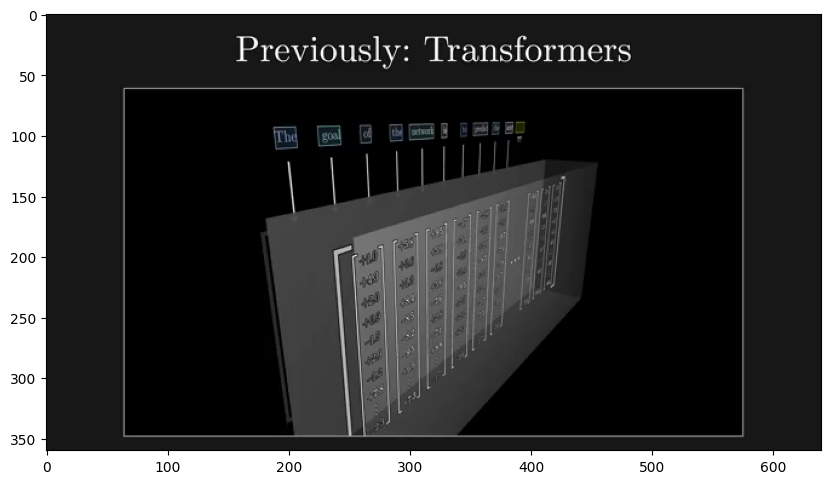

In [76]:
from transformers import pipeline

def summarize_text_file(input_text_file_path, output_summary_file_path, chunk_size=1000):
    # Load the summarization pipeline
    summarizer = pipeline("summarization")

    # Read the text from the file
    with open(input_text_file_path, "r") as text_file:
        text = text_file.read()

    # Split text into chunks
    text_chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]

    # Summarize each chunk and combine the results
    summary = ""
    for chunk in text_chunks:
        summarized_chunk = summarizer(chunk, max_length=130, min_length=30, do_sample=False)
        summary += summarized_chunk[0]['summary_text'] + " "

    # Print the summary
    print("\nSummary:\n", summary)

    # Save the summary to a file
    with open(output_summary_file_path, "w") as summary_file:
        summary_file.write(summary.strip())

    print(f"\nSummary saved to {output_summary_file_path}")

if __name__ == "__main__":
    input_text_file_path = "transcription.txt"  # Path to the transcription text file
    output_summary_file_path = "summary.txt"    # Path to save the summary
    summarize_text_file(input_text_file_path, output_summary_file_path)
test_video = "testme.mp4"
print(f"Test video path: {test_video}")

display_image_from_video(test_video)
